In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow as tf
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras import Model
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import load_model
from sklearn.utils import shuffle
from PIL import ImageFile
from sklearn.metrics import f1_score
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib
import noisereduce as nr
import re

Classification

In [15]:
image_path = "D:\\sec3_newtrim"  


In [16]:
spectrograms = os.listdir(image_path)

class_1_prefixes = {'f1_', 'f7_', 'f8_', 'm3_', 'm6_', 'm8_'}
file_labels = []

for file_name in spectrograms:
    prefix = file_name[:3] 
    script = '_'.join(file_name.split('_')[:2])  
    label = 1 if prefix in class_1_prefixes else 0
    file_labels.append([file_name, script, label])


df = pd.DataFrame(file_labels, columns=['file_name', 'script_id', 'label'])


df['file_name'] = df['file_name'].apply(lambda x: os.path.join(image_path, x))


print("Unique script IDs and their labels:")
print(df[['script_id', 'label']].drop_duplicates())

# grouping by script_id and label here
scripts = df[['script_id', 'label']].drop_duplicates()


train_val_ids, test_ids = train_test_split(
    scripts['script_id'],
    test_size=0.2,
    random_state=42,
    stratify=scripts['label']
)

train_ids, val_ids = train_test_split(
    train_val_ids,
    test_size=0.125,
    random_state=42,
    stratify=scripts[scripts['script_id'].isin(train_val_ids)]['label']
)


train_ids = list(train_ids)
val_ids = list(val_ids)
test_ids = list(test_ids)


def assign_set(script_id):
    if script_id in train_ids:
        return 'train'
    elif script_id in val_ids:
        return 'val'
    elif script_id in test_ids:
        return 'test'
    else:
        return 'unknown'

df['set'] = df['script_id'].apply(assign_set)


print("Dataset split counts:")
print(df['set'].value_counts())


print(f"Training set: {len(df[df['set'] == 'train'])} samples")
print(f"Validation set: {len(df[df['set'] == 'val'])} samples")
print(f"Test set: {len(df[df['set'] == 'test'])} samples")

# Display class counts for each split
for dataset in ['train', 'val', 'test']:
    subset = df[df['set'] == dataset]
    class_counts = subset['label'].value_counts()
    print(f"\n{dataset.capitalize()} set class distribution:")
    print(f"Class 0: {class_counts.get(0, 0)}")
    print(f"Class 1: {class_counts.get(1, 0)}")

df[df['set'] == 'train'].to_csv(os.path.join(image_path, 'train_set.csv'), index=False)
df[df['set'] == 'val'].to_csv(os.path.join(image_path, 'val_set.csv'), index=False)
df[df['set'] == 'test'].to_csv(os.path.join(image_path, 'test_set.csv'), index=False)

print("Datasets are split and saved in the folder:", image_path)
 

 

Unique script IDs and their labels:
          script_id  label
0       f10_script1      0
32      f10_script2      0
64      f10_script3      0
95      f10_script4      0
121     f10_script5      0
...             ...    ...
3785     m9_script4      0
3801     m9_script5      0
3817   test_set.csv      0
3818  train_set.csv      0
3819    val_set.csv      0

[103 rows x 2 columns]
Dataset split counts:
set
train    2570
test      818
val       432
Name: count, dtype: int64
Training set: 2570 samples
Validation set: 432 samples
Test set: 818 samples

Train set class distribution:
Class 0: 1333
Class 1: 1237

Val set class distribution:
Class 0: 187
Class 1: 245

Test set class distribution:
Class 0: 393
Class 1: 425
Datasets are split and saved in the folder: D:\sec3_newtrim


In [17]:

# Load the CSV files with the train, validation, and test splits
train_set = pd.read_csv(os.path.join(image_path, 'train_set.csv'))
val_set = pd.read_csv(os.path.join(image_path, 'val_set.csv'))
test_set = pd.read_csv(os.path.join(image_path, 'test_set.csv'))

def check_script_consistency(dataset, set_name):
    inconsistencies = dataset.groupby('script_id')['set'].nunique()
    inconsistent_scripts = inconsistencies[inconsistencies > 1]
    return inconsistent_scripts

train_inconsistencies = check_script_consistency(train_set, 'train')
val_inconsistencies = check_script_consistency(val_set, 'val')
test_inconsistencies = check_script_consistency(test_set, 'test')

train_balance = train_set['label'].value_counts(normalize=True)
val_balance = val_set['label'].value_counts(normalize=True)
test_balance = test_set['label'].value_counts(normalize=True)

script_distribution = {
    "train_scripts": train_set['script_id'].nunique(),
    "val_scripts": val_set['script_id'].nunique(),
    "test_scripts": test_set['script_id'].nunique(),
}

combined_set = pd.concat([train_set, val_set, test_set])
script_set_consistency = combined_set.groupby('script_id')['set'].nunique()
inconsistent_scripts_across_sets = script_set_consistency[script_set_consistency > 1]

{
    "train_inconsistencies": train_inconsistencies,
    "val_inconsistencies": val_inconsistencies,
    "test_inconsistencies": test_inconsistencies,
    "train_balance": train_balance,
    "val_balance": val_balance,
    "test_balance": test_balance,
    "script_distribution": script_distribution,
    "inconsistent_scripts_across_sets": inconsistent_scripts_across_sets
}

{'train_inconsistencies': Series([], Name: set, dtype: int64),
 'val_inconsistencies': Series([], Name: set, dtype: int64),
 'test_inconsistencies': Series([], Name: set, dtype: int64),
 'train_balance': label
 0    0.518677
 1    0.481323
 Name: proportion, dtype: float64,
 'val_balance': label
 1    0.56713
 0    0.43287
 Name: proportion, dtype: float64,
 'test_balance': label
 1    0.51956
 0    0.48044
 Name: proportion, dtype: float64,
 'script_distribution': {'train_scripts': 71,
  'val_scripts': 11,
  'test_scripts': 21},
 'inconsistent_scripts_across_sets': Series([], Name: set, dtype: int64)}

Simple Model

Found 2567 validated image filenames belonging to 2 classes.
Found 432 validated image filenames belonging to 2 classes.
Found 818 validated image filenames belonging to 2 classes.


c:\Program Files\Python38\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 3 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/5
81/81 [==============================] - 431s 5s/step - loss: 0.6008 - accuracy: 0.7433 - val_loss: 0.2715 - val_accuracy: 0.8773
Epoch 2/5
81/81 [==============================] - 449s 6s/step - loss: 0.2228 - accuracy: 0.9096 - val_loss: 0.1257 - val_accuracy: 0.9514
Epoch 3/5
81/81 [==============================] - 431s 5s/step - loss: 0.0766 - accuracy: 0.9778 - val_loss: 0.1095 - val_accuracy: 0.9583
Epoch 4/5
81/81 [==============================] - 425s 5s/step - loss: 0.0170 - accuracy: 0.9965 - val_loss: 0.1031 - val_accuracy: 0.9583
Epoch 5/5
81/81 [==============================] - 405s 5s/step - loss: 0.0064 - accuracy: 0.9992 - val_loss: 0.1182 - val_accuracy: 0.9583


c:\Program Files\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


818/818 [==============================] - 51s 63ms/step - loss: 0.3852 - accuracy: 0.8875
Test Accuracy: 88.75%
818/818 [==============================] - 54s 66ms/step
F1 Score: 0.89


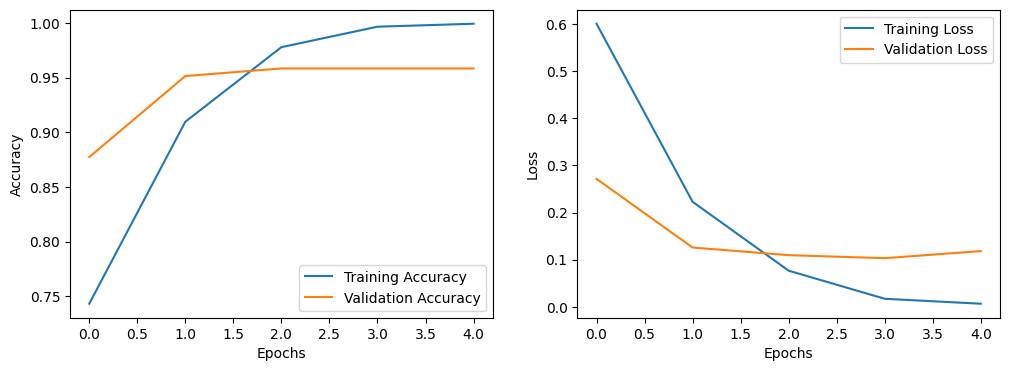

In [29]:
# Load the CSV files with the train, validation, and test splits
train_df = pd.read_csv(os.path.join(image_path, 'train_set.csv'))
val_df = pd.read_csv(os.path.join(image_path, 'val_set.csv'))
test_df = pd.read_csv(os.path.join(image_path, 'test_set.csv'))
 
# Image dimensions
IMG_HEIGHT = 512
IMG_WIDTH = 512
BATCH_SIZE = 32
 
 
 
# Convert label column to string type for compatibility with binary class mode
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)
 

train_datagen = ImageDataGenerator(rescale=1./255,)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators for loading the images
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file_name',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
 
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='file_name',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
 
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='file_name',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# Build the CNN model with Dropout layers to prevent overfitting
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
   
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])
 
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
 
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=3,               # Number of epochs without improvement before stopping
    restore_best_weights=True # Restore the model weights from the epoch with the best value
)
 
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,  
    epochs=5
)

# Save the trained model
model.save('D:\\Models\\SimpleModel.h5')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')
 
# Predict the labels for the test set
y_pred_probs = model.predict(test_generator)
 
# Convert y_pred to strings to match y_true
y_pred = (y_pred_probs > 0.5).astype(int).astype(str).ravel()
 
# Get the true labels (they are already strings)
y_true = test_df['label'].values
 
# Calculate F1 score
f1 = f1_score(y_true, y_pred, pos_label='1', average='binary')
print(f'F1 Score: {f1:.2f}')
 
# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
 
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
 
plt.show()

Normal Model

Found 2567 validated image filenames belonging to 2 classes.
Found 432 validated image filenames belonging to 2 classes.
Found 818 validated image filenames belonging to 2 classes.


c:\Program Files\Python38\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 3 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/10
81/81 [==============================] - 548s 7s/step - loss: 0.6726 - accuracy: 0.6993 - val_loss: 0.4420 - val_accuracy: 0.8102
Epoch 2/10
81/81 [==============================] - 534s 7s/step - loss: 0.3682 - accuracy: 0.8434 - val_loss: 0.2550 - val_accuracy: 0.8912
Epoch 3/10
81/81 [==============================] - 554s 7s/step - loss: 0.2229 - accuracy: 0.9151 - val_loss: 0.1333 - val_accuracy: 0.9468
Epoch 4/10
81/81 [==============================] - 585s 7s/step - loss: 0.1224 - accuracy: 0.9568 - val_loss: 0.1378 - val_accuracy: 0.9491
Epoch 5/10
81/81 [==============================] - 578s 7s/step - loss: 0.0653 - accuracy: 0.9758 - val_loss: 0.1354 - val_accuracy: 0.9560
Epoch 6/10
81/81 [==============================] - 576s 7s/step - loss: 0.0243 - accuracy: 0.9914 - val_loss: 0.1633 - val_accuracy: 0.9491
Epoch 7/10
81/81 [==============================] - 577s 7s/step - loss: 0.0148 - accuracy: 0.9953 - val_loss: 0.1548 - val_accuracy: 0.9514
Epoch 8/10
81

c:\Program Files\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


818/818 [==============================] - 79s 96ms/step - loss: 0.4769 - accuracy: 0.8888
Test Accuracy: 88.88%
818/818 [==============================] - 80s 97ms/step
F1 Score: 0.89


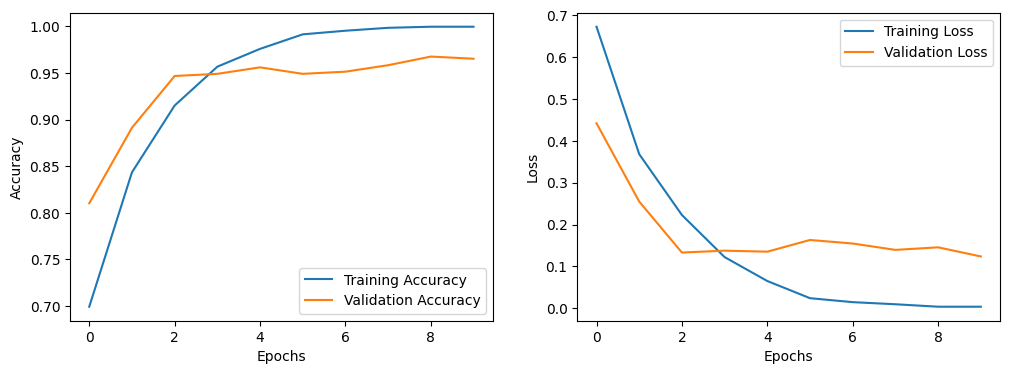

In [31]:
# Load the CSV files with the train, validation, and test splits
train_df = pd.read_csv(os.path.join(image_path, 'train_set.csv'))
val_df = pd.read_csv(os.path.join(image_path, 'val_set.csv'))
test_df = pd.read_csv(os.path.join(image_path, 'test_set.csv'))
 
# Image dimensions
IMG_HEIGHT = 512
IMG_WIDTH = 512
BATCH_SIZE = 32
 
 
 
# Convert label column to string type for compatibility with binary class mode
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)
 

train_datagen = ImageDataGenerator(rescale=1./255,)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators for loading the images
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file_name',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
 
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='file_name',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
 
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='file_name',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# Build the CNN model with Dropout layers to prevent overfitting
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
   
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])
 
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
 
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=3,               # Number of epochs without improvement before stopping
    restore_best_weights=True # Restore the model weights from the epoch with the best value
)
 
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,  
    epochs=10
)

# Save the trained model
model.save('D:\\Models\\NormalModel.h5')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')
 
# Predict the labels for the test set
y_pred_probs = model.predict(test_generator)
 
# Convert y_pred to strings to match y_true
y_pred = (y_pred_probs > 0.5).astype(int).astype(str).ravel()
 
# Get the true labels (they are already strings)
y_true = test_df['label'].values
 
# Calculate F1 score
f1 = f1_score(y_true, y_pred, pos_label='1', average='binary')
print(f'F1 Score: {f1:.2f}')
 
# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
 
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
 
plt.show()

Complex Model

Found 2567 validated image filenames belonging to 2 classes.
Found 432 validated image filenames belonging to 2 classes.


c:\Program Files\Python38\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 3 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


Found 818 validated image filenames belonging to 2 classes.
Epoch 1/7
81/81 [==============================] - 698s 9s/step - loss: 0.6348 - accuracy: 0.6673 - val_loss: 0.5273 - val_accuracy: 0.7847
Epoch 2/7
81/81 [==============================] - 694s 9s/step - loss: 0.4420 - accuracy: 0.8013 - val_loss: 0.4492 - val_accuracy: 0.7986
Epoch 3/7
81/81 [==============================] - 662s 8s/step - loss: 0.2894 - accuracy: 0.8714 - val_loss: 0.2512 - val_accuracy: 0.8866
Epoch 4/7
81/81 [==============================] - 671s 8s/step - loss: 0.1967 - accuracy: 0.9260 - val_loss: 0.1424 - val_accuracy: 0.9537
Epoch 5/7
81/81 [==============================] - 642s 8s/step - loss: 0.1266 - accuracy: 0.9505 - val_loss: 0.1967 - val_accuracy: 0.9097
Epoch 6/7
81/81 [==============================] - 702s 9s/step - loss: 0.0843 - accuracy: 0.9688 - val_loss: 0.0528 - val_accuracy: 0.9861
Epoch 7/7
81/81 [==============================] - 684s 9s/step - loss: 0.0633 - accuracy: 0.9774 - 

c:\Program Files\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


818/818 [==============================] - 59s 72ms/step - loss: 0.2333 - accuracy: 0.9303
Test Accuracy: 93.03%
818/818 [==============================] - 57s 69ms/step
F1 Score: 0.94


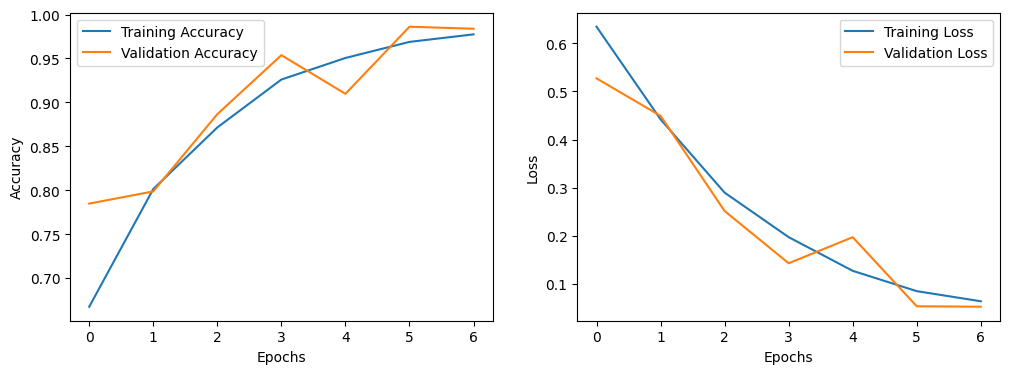

In [38]:
# Load the CSV files with the train, validation, and test splits
train_df = pd.read_csv(os.path.join(image_path, 'train_set.csv'))
val_df = pd.read_csv(os.path.join(image_path, 'val_set.csv'))
test_df = pd.read_csv(os.path.join(image_path, 'test_set.csv'))

# Image dimensions
IMG_HEIGHT = 512
IMG_WIDTH = 512
BATCH_SIZE = 32

# Data generators for loading the images
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Convert label column to string type for compatibility with binary class mode
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

# Data generators for loading the images
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file_name',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='file_name',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='file_name',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)


# Build the CNN model with Dropout layers to prevent overfitting
model = Sequential([
    Conv2D(32, (3, 3), activation='relu',  input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=5,               # Number of epochs without improvement before stopping
    restore_best_weights=True # Restore the model weights from the epoch with the best value
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,  
    epochs=7,
    callbacks=[early_stopping]  
)

# Save the trained model
model.save('D:\\Models\\ComplexModel.h5')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Predict the labels for the test set
y_pred_probs = model.predict(test_generator)

# Convert y_pred to strings to match y_true
y_pred = (y_pred_probs > 0.5).astype(int).astype(str).ravel()

# Get the true labels (they are already strings)
y_true = test_df['label'].values

# Calculate F1 score
f1 = f1_score(y_true, y_pred, pos_label='1', average='binary')
print(f'F1 Score: {f1:.2f}')

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


comparing the models


818/818 [==============================] - 58s 70ms/step
Simple Model - Test Accuracy: 88.75%, F1 Score: 0.89
Normal Model - Test Accuracy: 88.88%, F1 Score: 0.89
Complex Model - Test Accuracy: 93.03%, F1 Score: 0.94


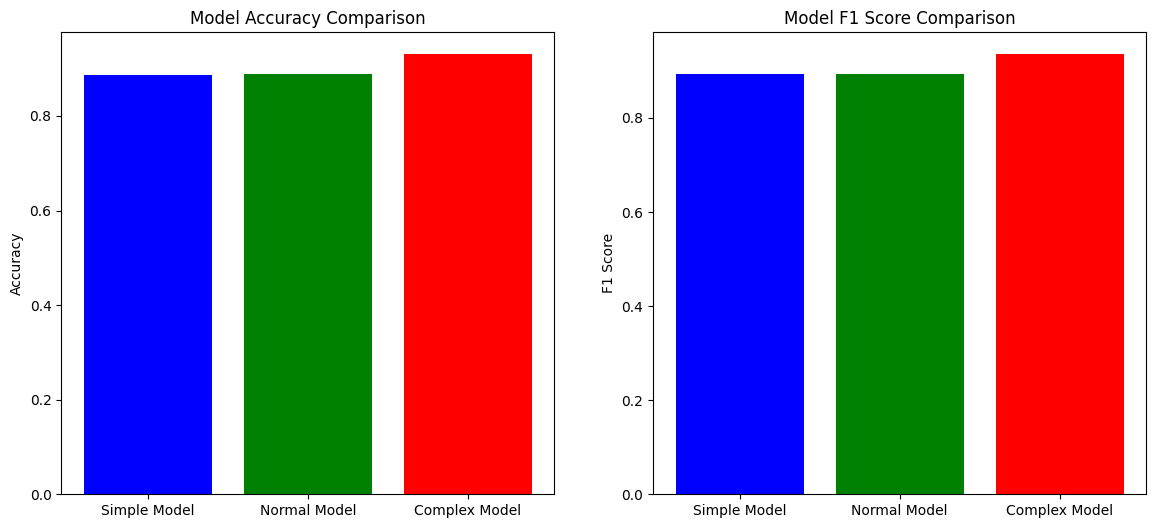

In [40]:
# Load all three models
simple_model = load_model('D:\\Models\\SimpleModel.h5')
normal_model = load_model('D:\\Models\\NormalModel.h5')
complex_model = load_model('D:\\Models\\ComplexModel.h5')

# Evaluate all three models on the test set
simple_loss, simple_accuracy = simple_model.evaluate(test_generator)
normal_loss, normal_accuracy = normal_model.evaluate(test_generator)
complex_loss, complex_accuracy = complex_model.evaluate(test_generator)

# Predict with each model to calculate F1 scores
simple_y_pred_probs = simple_model.predict(test_generator)
normal_y_pred_probs = normal_model.predict(test_generator)
complex_y_pred_probs = complex_model.predict(test_generator)

# Convert predictions to binary labels
simple_y_pred = (simple_y_pred_probs > 0.5).astype(int).astype(str).ravel()
normal_y_pred = (normal_y_pred_probs > 0.5).astype(int).astype(str).ravel()
complex_y_pred = (complex_y_pred_probs > 0.5).astype(int).astype(str).ravel()

# Calculate F1 scores
simple_f1 = f1_score(y_true, simple_y_pred, pos_label='1', average='binary')
normal_f1 = f1_score(y_true, normal_y_pred, pos_label='1', average='binary')
complex_f1 = f1_score(y_true, complex_y_pred, pos_label='1', average='binary')

# Print out the stats
print(f"Simple Model - Test Accuracy: {simple_accuracy * 100:.2f}%, F1 Score: {simple_f1:.2f}")
print(f"Normal Model - Test Accuracy: {normal_accuracy * 100:.2f}%, F1 Score: {normal_f1:.2f}")
print(f"Complex Model - Test Accuracy: {complex_accuracy * 100:.2f}%, F1 Score: {complex_f1:.2f}")

# Plot comparison of accuracy and F1 scores
labels = ['Simple Model', 'Normal Model', 'Complex Model']
accuracies = [simple_accuracy, normal_accuracy, complex_accuracy]
f1_scores = [simple_f1, normal_f1, complex_f1]

plt.figure(figsize=(14, 6))

# Plot accuracies
plt.subplot(1, 2, 1)
plt.bar(labels, accuracies, color=['blue', 'green', 'red'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

# Plot F1 scores
plt.subplot(1, 2, 2)
plt.bar(labels, f1_scores, color=['blue', 'green', 'red'])
plt.ylabel('F1 Score')
plt.title('Model F1 Score Comparison')

plt.show()
